In [1]:
import ambulance_game as abg
import numpy as np
import math
import matplotlib.pyplot as plt

# <ins> Theoretical waiting times:</ins> (M/M/c/$\infty$)


$$ W_q = \frac{(c \rho)^c}{c! \mu c (1 - \rho)^2} P_0$$

In [2]:
def probability_no_people_in_the_system(traffic_intensity, num_of_servers):
    denominator = 0
    for i in range(num_of_servers):
        denominator += ((num_of_servers * traffic_intensity) ** i) / math.factorial(i)
    denominator += ((num_of_servers * traffic_intensity) ** num_of_servers) / (
        math.factorial(num_of_servers) * (1 - traffic_intensity)
    )
    return 1 / denominator


def get_theoretical_waiting_time(Lambda, mu, num_of_servers):
    traffic_intensity = Lambda / (num_of_servers * mu)
    prob_0 = probability_no_people_in_the_system(traffic_intensity, num_of_servers)

    wait = ((num_of_servers * traffic_intensity) ** num_of_servers) / (
        math.factorial(num_of_servers)
        * mu
        * num_of_servers
        * (1 - traffic_intensity) ** 2
    )
    wait *= prob_0

    return wait


# <ins> Waiting Time from state probabilities:<ins>


#### Waiting States


<!--     Ambulance (old):
$$ S_w^A = \{ (u,v) \in S \; | \; u=0 \;, \; C \leq v \leq T \} $$
     -->
    Ambulance:
$$ S_w^A = \{ (u,v) \in S \; | v \geq C \} $$

    Other: 
$$ S_w^o = \{ (u,v) \in S \; | \; v \geq C \} $$

In [3]:
### CHANGED ###
def is_waiting_state(state, patient_type, num_of_servers, threshold):
    if patient_type == "ambulance":
#         condition = state[0] == 0 and num_of_servers <= state[1] < threshold
        condition = num_of_servers <= state[1]
    if patient_type == "others":
        condition = state[1] >= num_of_servers
    return condition

#### Accepting States


    Ambulance:
$$ S_A^A = \{ (u,v) \in S \; | \; u < N \} $$

    Other:
$$ S_A^o = \{ (u,v) \in S \; | \; v < M \} $$

In [4]:
def is_accepting_state(state, patient_type, system_capacity, parking_capacity):
    if patient_type == "ambulance":
        condition = state[0] < parking_capacity
    if patient_type == "others":
        condition = state[1] < system_capacity
    return condition

#### Expected waiting time in a state (ignoring any arrivals after the individual's arrival):

<!-- Old: $$ c(u,v) = \frac{1}{min(v,C) \mu} $$ -->
 
$$ 
    c(u,v) = 
       \begin{cases} 
           0, & \textbf{if } v > 0 \\
           \frac{1}{min(v,C) \mu}, & \textbf{otherwise}
       \end{cases}
$$

In [5]:
def expected_time_in_markov_state_ignoring_arrivals(state, patient_type, num_of_servers, mu):
    if patient_type == "ambulance" and state[0] > 0:
        return 0
    return 1 / (min(state[1], num_of_servers) * mu)

#### Waiting time of an individual when arriving at state (u,v):


$$ P_s(u,v) = 1 $$

<!-- $$ P_s(u,v) = \frac{\text{min}(v,C)\mu}{\text{min}(1, N - v)\lambda^o + \text{ min}(1, M - u)\lambda_A + \text{ min}(v,C)\mu} $$ -->

$$ 
w(u,v) = 
\begin{cases} 
    0, \hspace{4.85cm} \textbf{if } v < C \\
    c(u,v) + P_s w(u-1, v), \hspace{1cm} \textbf{if } u \geq 1 \textbf{ and } v = t \\
    c(u,v) + P_s w(u, v-1), \hspace{1cm} \textbf{otherwise} \\
\end{cases}
$$

In [6]:
def probability_of_service(
    state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity
):
    return 1


def get_recursive_waiting_time(
    state,
    patient_type,
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
):

    if not is_waiting_state(state, patient_type, num_of_servers, threshold):
        return 0
    
    ### CHANGED ###
    if patient_type == "ambulance" and state[1] >= threshold:
        wait = expected_time_in_markov_state_ignoring_arrivals((state[0] + 1, state[1]), patient_type, num_of_servers, mu) 
    else:
        wait = expected_time_in_markov_state_ignoring_arrivals((state[0], state[1] + 1), patient_type, num_of_servers, mu)
    
    if state[0] >= 1 and state[1] == threshold:
        if patient_type == "ambulance":
            wait += get_recursive_waiting_time(
                (state[0] - 1, state[1]),
                patient_type,
                lambda_a,
                lambda_o,
                mu,
                num_of_servers,
                threshold,
                system_capacity,
                parking_capacity,
            )
            return wait
        
        if patient_type == "others":
            wait += get_recursive_waiting_time(
                (0, state[1] - 1),
                patient_type,
                lambda_a,
                lambda_o,
                mu,
                num_of_servers,
                threshold,
                system_capacity,
                parking_capacity,
            )
            return wait
        

    wait += probability_of_service(
        state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity
    ) * get_recursive_waiting_time(
        (state[0], state[1] - 1),
        patient_type,
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
    )
    return wait

#### Mean Waiting Time:


$$ W = \frac{\sum_{(u,v) \in S_A} \pi_{(u,v)} \; w(u,v)}{\sum_{(u,v) \in S_A} \pi_{(u,v)}} $$

In [7]:
def mean_waiting_time_formula(
    all_states,
    pi,
    patient_type,
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
):
    mean_waiting_time = 0
    probability_of_accepting = 0
    for u, v in all_states:
        if is_accepting_state((u, v), patient_type, system_capacity, parking_capacity):
            current_state_wait = get_recursive_waiting_time(
                (u, v),
                patient_type,
                lambda_a,
                lambda_o,
                mu,
                num_of_servers,
                threshold,
                system_capacity,
                parking_capacity,
            )
            mean_waiting_time += current_state_wait * pi[u, v]
            probability_of_accepting += pi[u, v]
#             print((u,v), current_state_wait, pi[u, v])
    mean_waiting_time /= probability_of_accepting
    return mean_waiting_time


#### Main functions:


    Using simulation state probabilities

In [8]:
def get_mean_waiting_time_simulation(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    seed_num,
    num_of_trials,
    output="both",
):
    state_probabilities = abg.simulation.get_average_simulated_state_probabilities(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
        seed_num=seed_num,
        num_of_trials=num_of_trials,
    )
    all_states = [
        (u, v)
        for v in range(state_probabilities.shape[1])
        for u in range(state_probabilities.shape[0])
        if state_probabilities[u, v] > 0
    ]

    if output == "others" or output == "both":
        mean_waiting_time_other = mean_waiting_time_formula(
            all_states,
            state_probabilities,
            "others",
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
        )

    if output == "ambulance" or output == "both":
        mean_waiting_time_ambulance = 0
        ### CHANGED ###
#         if threshold > num_of_servers:
        mean_waiting_time_ambulance = mean_waiting_time_formula(
            all_states,
            state_probabilities,
            "ambulance",
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
        )

    if output == "others":
        return mean_waiting_time_other
    if output == "ambulance":
        return mean_waiting_time_ambulance
    if output == "both":
        ambulance_rate = lambda_a / (lambda_a + lambda_o)
        others_rate = lambda_o / (lambda_a + lambda_o)
        return mean_waiting_time_ambulance * ambulance_rate + mean_waiting_time_other * others_rate


    Using Markov state probabilities

In [9]:
def get_mean_waiting_time_markov(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    output="both",
):
    transition_matrix = abg.markov.get_transition_matrix(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
    )
    pi = abg.markov.get_steady_state_algebraically(
        transition_matrix, algebraic_function=np.linalg.solve
    )
    all_states = abg.markov.build_states(threshold, system_capacity, parking_capacity)
    state_probabilities = abg.markov.get_markov_state_probabilities(
        pi, all_states, output=np.ndarray
    )

    if output == "others" or output == "both":
        mean_waiting_time_other = mean_waiting_time_formula(
            all_states,
            state_probabilities,
            "others",
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
        )

    if output == "ambulance" or output == "both":
        mean_waiting_time_ambulance = 0
        ### CHANGED ###
#         if threshold > num_of_servers:
        mean_waiting_time_ambulance = mean_waiting_time_formula(
            all_states,
            state_probabilities,
            "ambulance",
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
        )

    if output == "others":
        return mean_waiting_time_other
    if output == "ambulance":
        return mean_waiting_time_ambulance
    if output == "both":
        ambulance_rate = lambda_a / (lambda_a + lambda_o)
        others_rate = lambda_o / (lambda_a + lambda_o)
        return mean_waiting_time_ambulance * ambulance_rate + mean_waiting_time_other * others_rate

# <ins>Plot:<ins>


In [10]:
def get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output="both",
    plot_over="lamda_a",
    max_parameter_value=1,
    accuracy=None,
):
    all_times_sim = []
    all_mean_times_sim = []
    all_mean_times_markov = []

    if accuracy == None or accuracy <= 1:
        accuracy = 5

    if plot_over == "lambda_a":
        range_space = np.linspace(lambda_a, max_parameter_value, accuracy)
    elif plot_over == "lambda_o":
        range_space = np.linspace(lambda_o, max_parameter_value, accuracy)
    elif plot_over == "mu":
        range_space = np.linspace(mu, max_parameter_value, accuracy)
    elif plot_over == "num_of_servers":
        range_space = np.linspace(num_of_servers, max_parameter_value, accuracy)
    elif plot_over == "threshold":
        range_space = np.linspace(threshold, max_parameter_value, accuracy)
    elif plot_over == "system_capacity":
        range_space = np.linspace(system_capacity, max_parameter_value, accuracy)
    elif plot_over == "parking_capacity":
        range_space = np.linspace(parking_capacity, max_parameter_value, accuracy)
    else:
        return "Arguement plot_over invalid"

    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_o = parameter
        elif plot_over == "mu":
            mu = parameter
        elif plot_over == "num_of_servers":
            num_of_servers = parameter
        elif plot_over == "threshold":
            threshold = parameter
        elif plot_over == "system_capacity":
            system_capacity = parameter
        elif plot_over == "parking_capacity":
            parking_capacity = parameter

        num_of_servers = int(num_of_servers)
        threshold = int(threshold)
        system_capacity = int(system_capacity)
        parking_capacity = int(parking_capacity)

        times = abg.simulation.get_multiple_runs_results(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            num_of_trials=num_of_trials,
            seed_num=seed_num,
            runtime=runtime,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            patient_type=output
        )
        simulation_waiting_times = [np.mean(w.waiting_times) for w in times]
        mean_waiting_time_sim = get_mean_waiting_time_simulation(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
            seed_num=seed_num,
            num_of_trials=num_of_trials,
            output=output,
        )
        mean_waiting_time_markov = get_mean_waiting_time_markov(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
            output=output,
        )

        all_times_sim.append(simulation_waiting_times)
        all_mean_times_sim.append(mean_waiting_time_sim)
        all_mean_times_markov.append(mean_waiting_time_markov)

    diff = (range_space[1] - range_space[0]) / 2

    plt.figure(figsize=(20, 10))
    plt.plot(range_space, all_mean_times_sim, label="Simulation State probabilities")
    plt.plot(range_space, all_mean_times_markov, label="Markov State probabilities")
    plt.violinplot(
        all_times_sim,
        positions=range_space,
        widths=diff,
        showmeans=True,
        showmedians=False,
    )
    title = (
        "lambda_a="
        + str(lambda_a)
        + ", lambda_o="
        + str(lambda_o)
        + ", mu="
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", T="
        + str(threshold)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(parking_capacity)
    )
    plt.title(title)
    plt.xlabel(plot_over)
    plt.ylabel("Waiting time")
    plt.legend()
    plt.show()
    return range_space, all_mean_times_sim, all_mean_times_markov, all_times_sim


In [17]:
def get_plot_of_difference(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output="both",
    plot_over="lamda_a",
    max_parameter_value=1,
    accuracy=None,
):
    all_differences = []

    if accuracy == None or accuracy <= 1:
        accuracy = 5

    if plot_over == "lambda_a":
        range_space = np.linspace(lambda_a, max_parameter_value, accuracy)
    elif plot_over == "lambda_o":
        range_space = np.linspace(lambda_o, max_parameter_value, accuracy)
    elif plot_over == "mu":
        range_space = np.linspace(mu, max_parameter_value, accuracy)
    elif plot_over == "num_of_servers":
        range_space = np.linspace(num_of_servers, max_parameter_value, accuracy)
    elif plot_over == "threshold":
        range_space = np.linspace(threshold, max_parameter_value, accuracy)
    elif plot_over == "system_capacity":
        range_space = np.linspace(system_capacity, max_parameter_value, accuracy)
    elif plot_over == "parking_capacity":
        range_space = np.linspace(parking_capacity, max_parameter_value, accuracy)
    else:
        return "Arguement plot_over invalid"

    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_o = parameter
        elif plot_over == "mu":
            mu = parameter
        elif plot_over == "num_of_servers":
            num_of_servers = parameter
        elif plot_over == "threshold":
            threshold = parameter
        elif plot_over == "system_capacity":
            system_capacity = parameter
        elif plot_over == "parking_capacity":
            parking_capacity = parameter

        num_of_servers = int(num_of_servers)
        threshold = int(threshold)
        system_capacity = int(system_capacity)
        parking_capacity = int(parking_capacity)

        mean_waiting_time_sim = get_mean_waiting_time_simulation(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
            seed_num=seed_num,
            num_of_trials=num_of_trials,
            output=output,
        )
        mean_waiting_time_markov = get_mean_waiting_time_markov(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
            output=output,
        )
        all_differences.append(mean_waiting_time_markov - mean_waiting_time_sim)


    plt.figure(figsize=(20, 10))
    plt.plot(range_space, all_differences, label="Markov waiting time - Simulation waiting time")
    title = (
        "lambda_a="
        + str(lambda_a)
        + ", lambda_o="
        + str(lambda_o)
        + ", mu="
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", T="
        + str(threshold)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(parking_capacity)
    )
    plt.title(title)
    plt.xlabel(plot_over)
    plt.ylabel("Waiting time")
    plt.legend()
    plt.show()
    return range_space, all_differences


# <ins>Results:<ins>


In [91]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.2
num_of_servers = 4
threshold = 3
system_capacity = 10
parking_capacity = 10

num_of_trials = 100
seed_num = None
runtime = 10000
output = "others"
accuracy = 10

#### Hatmaps


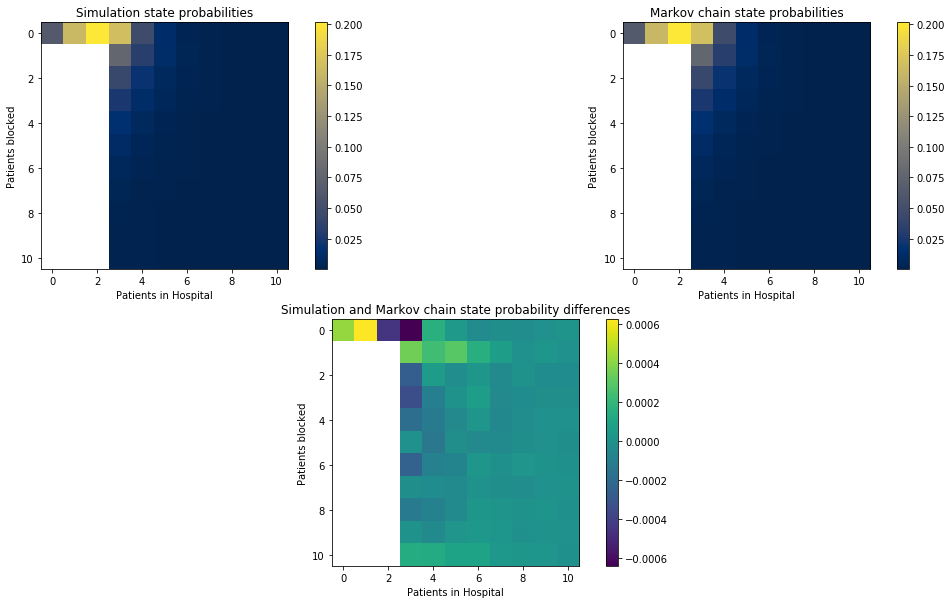

In [92]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


#### Other patietns waiting times


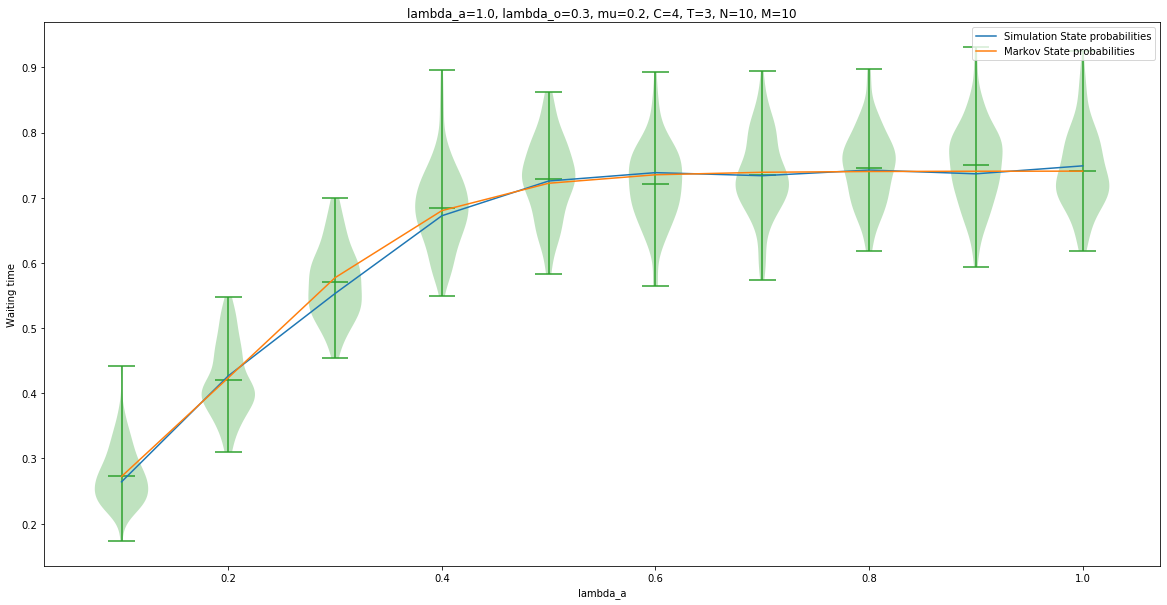

In [93]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


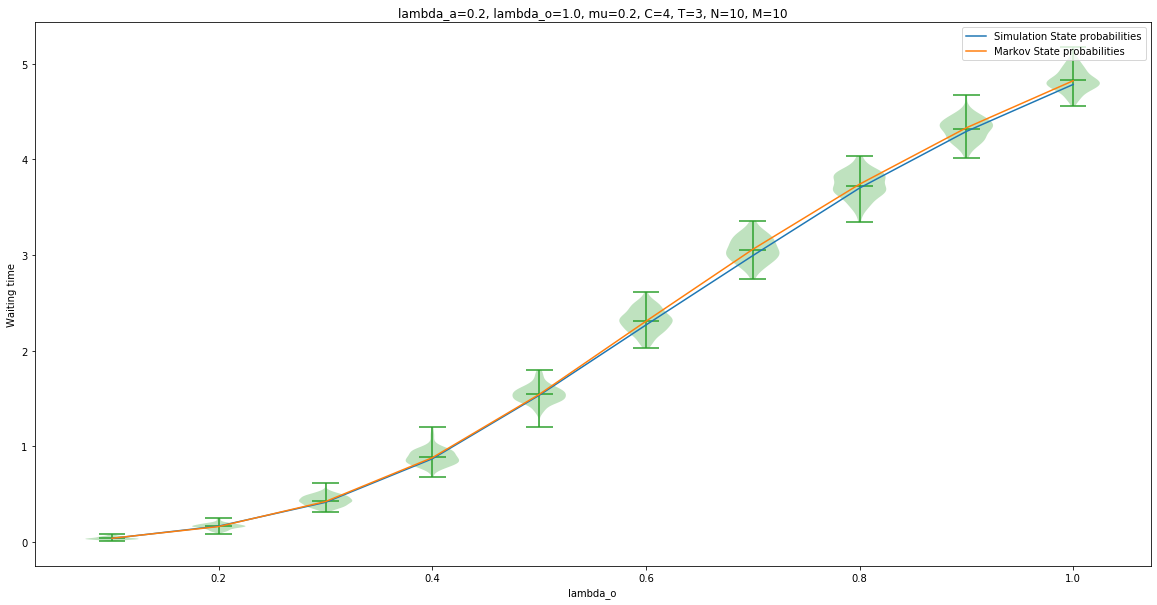

In [94]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


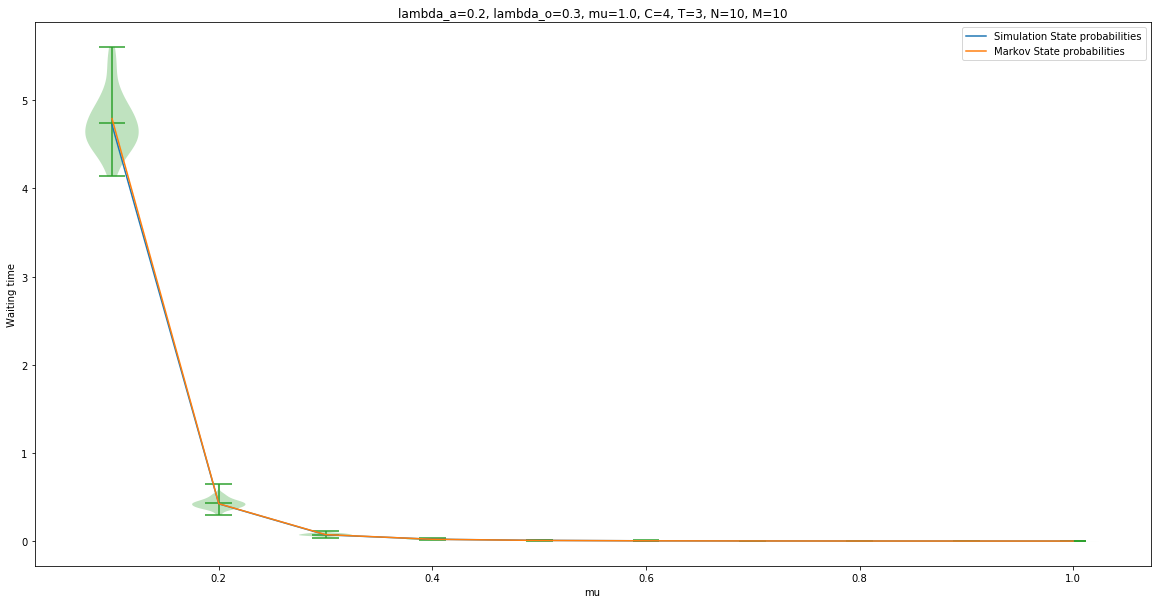

In [95]:
plot_over = "mu"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    0.1,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


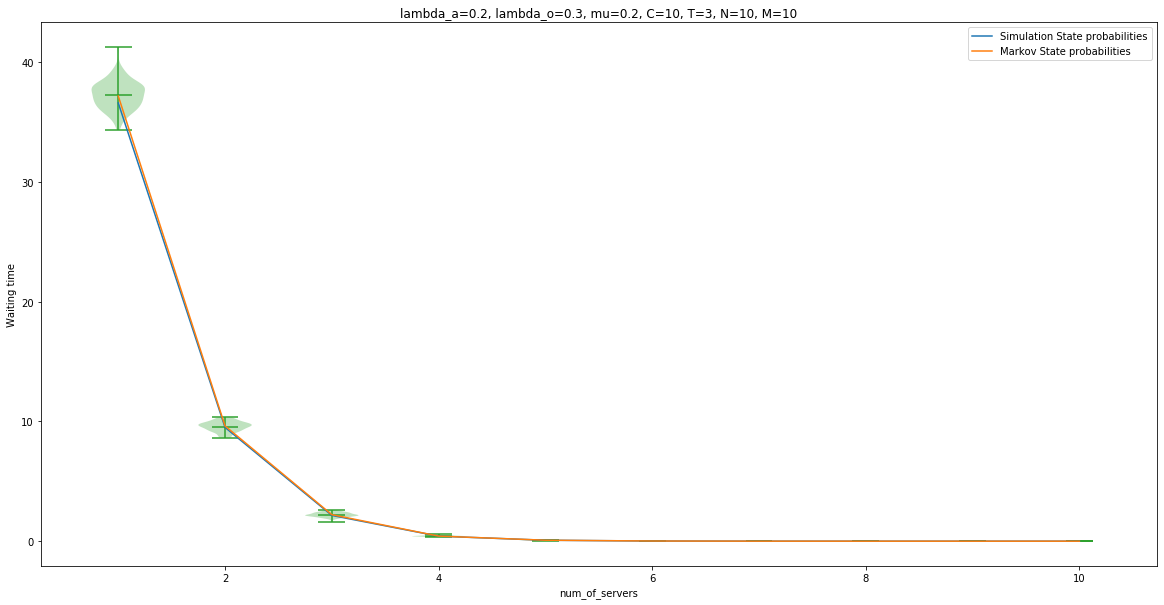

In [96]:
plot_over = "num_of_servers"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    1,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


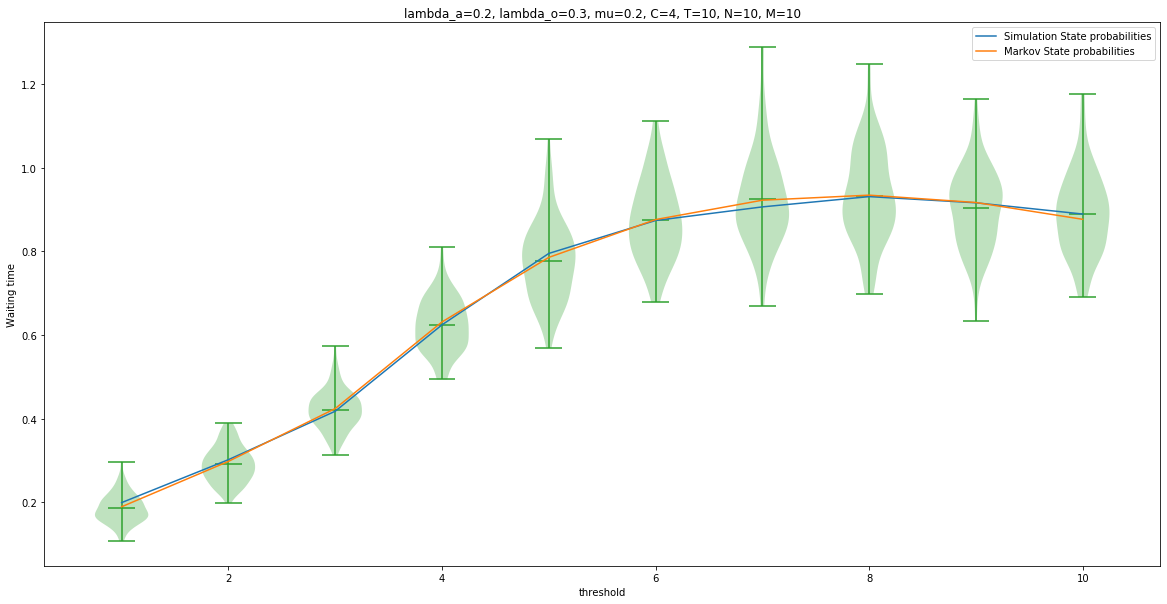

In [97]:
plot_over = "threshold"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    1,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


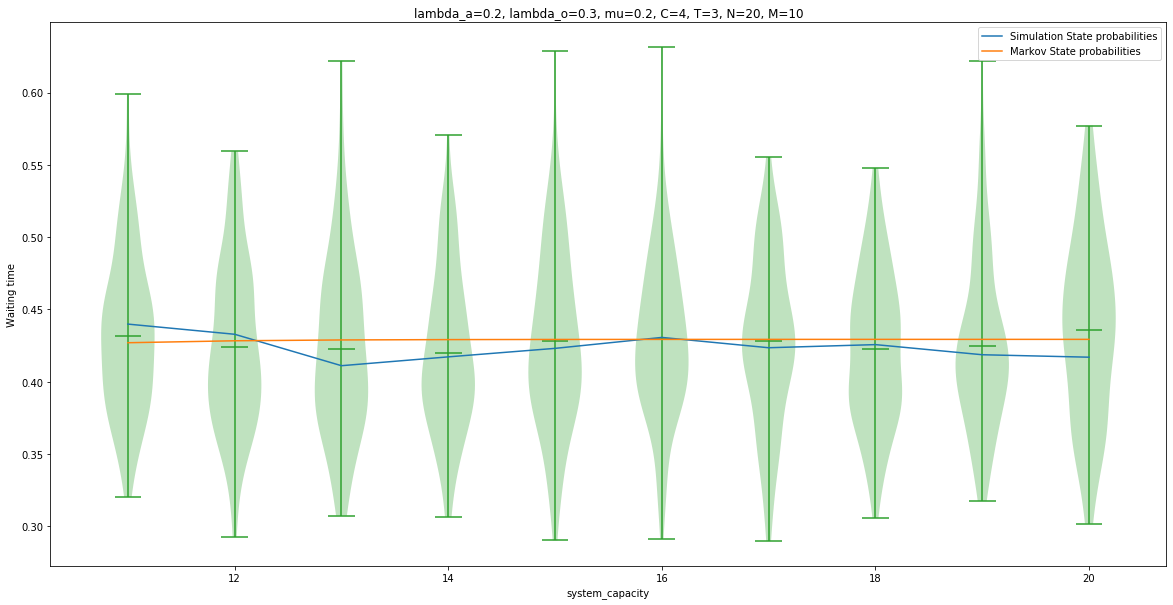

In [98]:
plot_over = "system_capacity"
max_parameter_value = 20
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    11,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


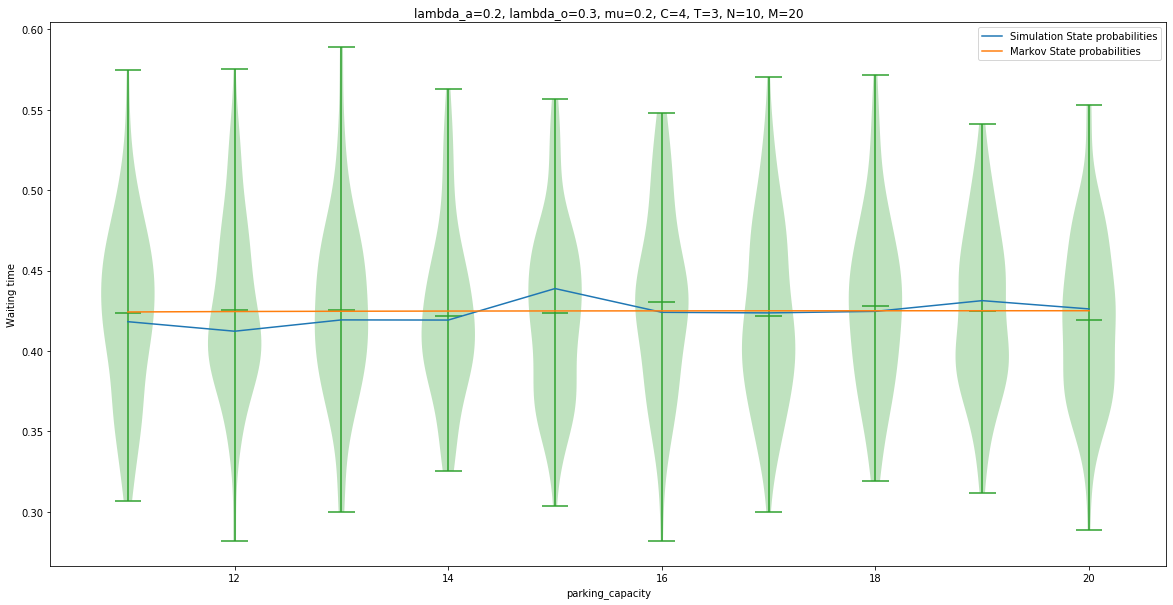

In [99]:
plot_over = "parking_capacity"
max_parameter_value = 20
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    11,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


#### Ambulance patients waiting times:


In [156]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.2
num_of_servers = 5
threshold = 6
system_capacity = 20
parking_capacity = 20

num_of_trials = 100
seed_num = None
runtime = 10000
output = "ambulance"
accuracy = 10

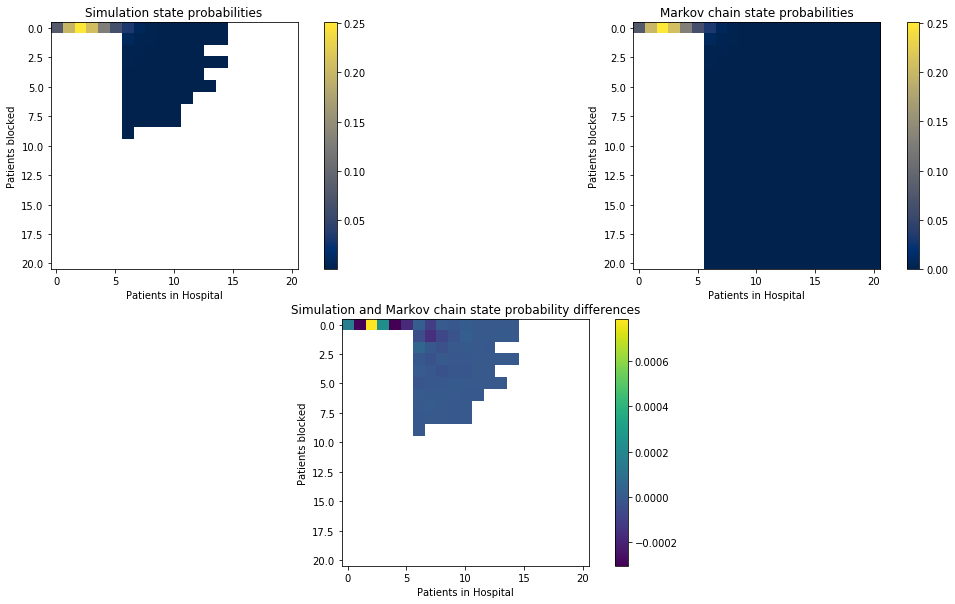

In [157]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)

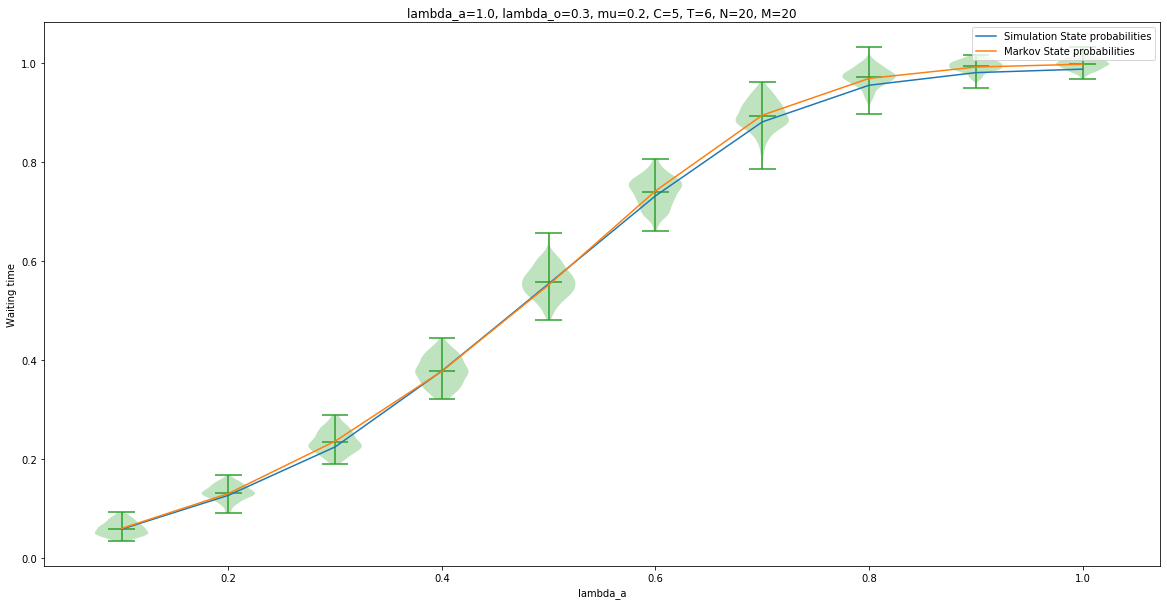

In [158]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

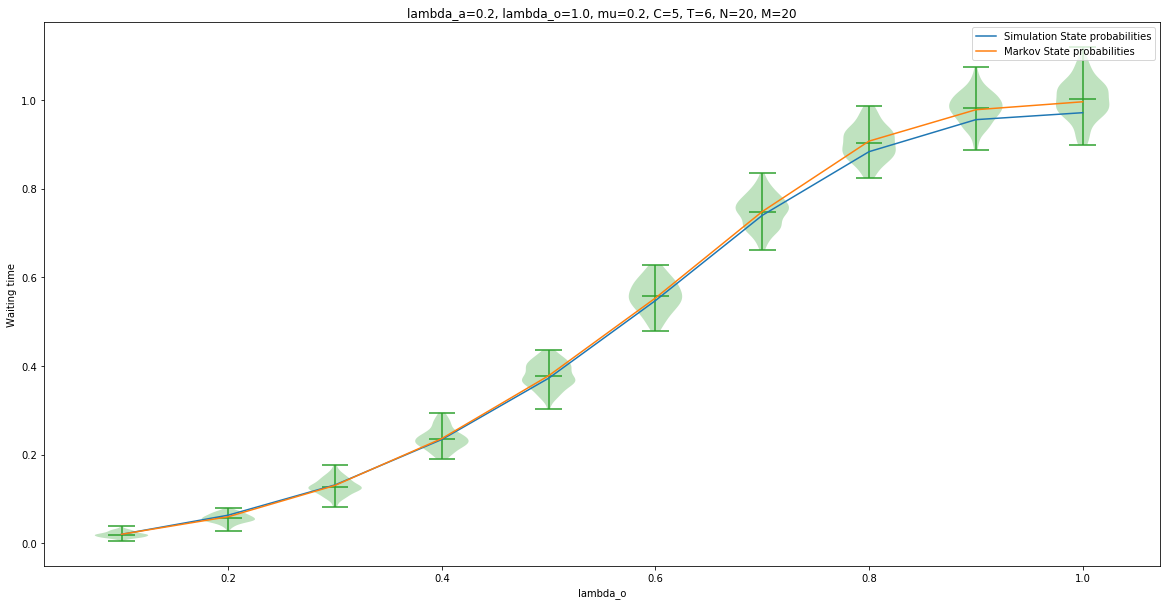

In [159]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

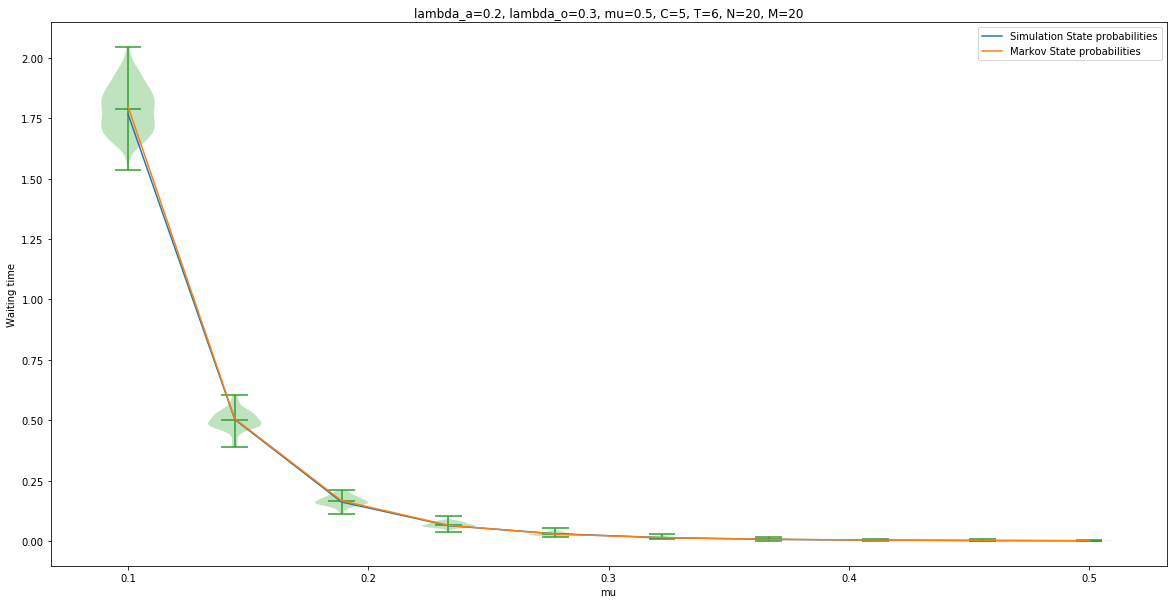

In [160]:
plot_over = "mu"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    0.1,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


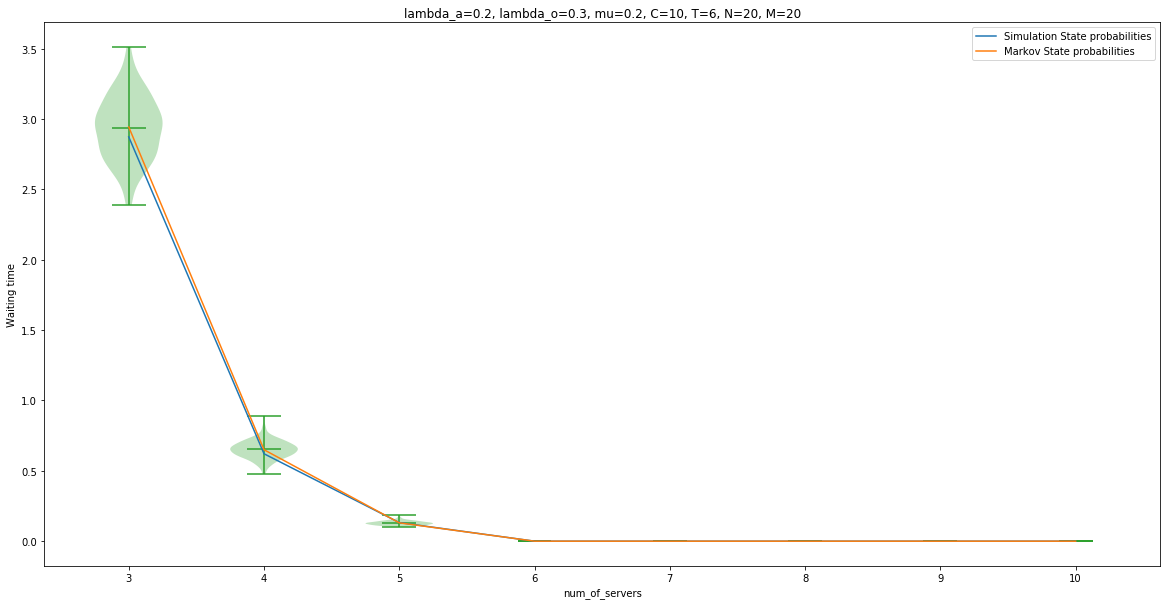

In [161]:
plot_over = "num_of_servers"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    3,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    8,
)


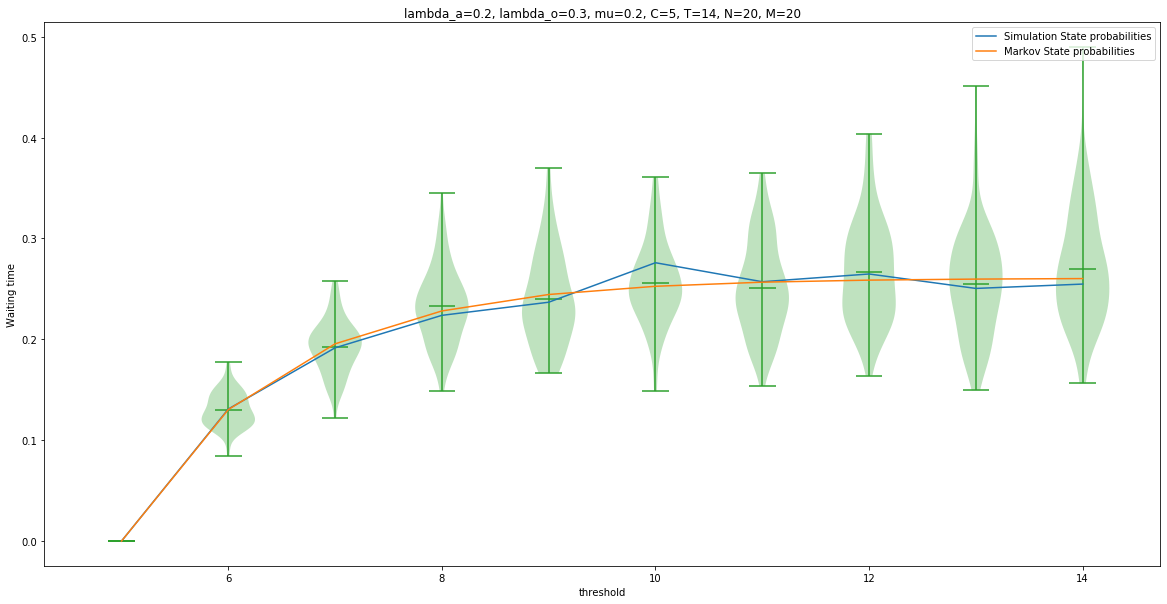

In [162]:
plot_over = "threshold"
max_parameter_value = 14
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    5,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


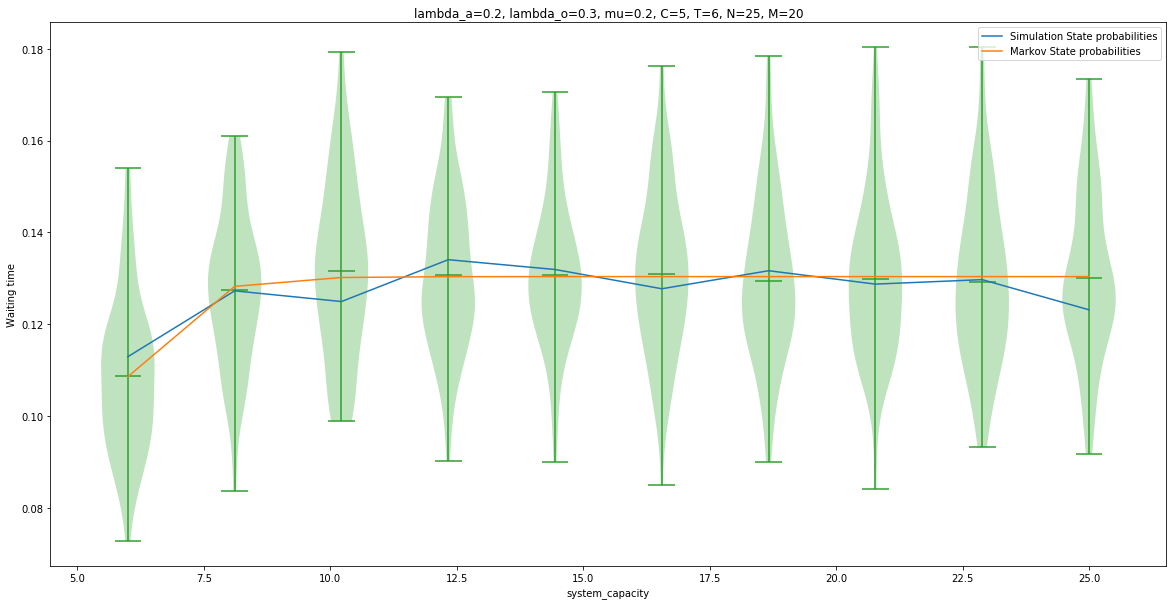

In [163]:
plot_over = "system_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    6,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


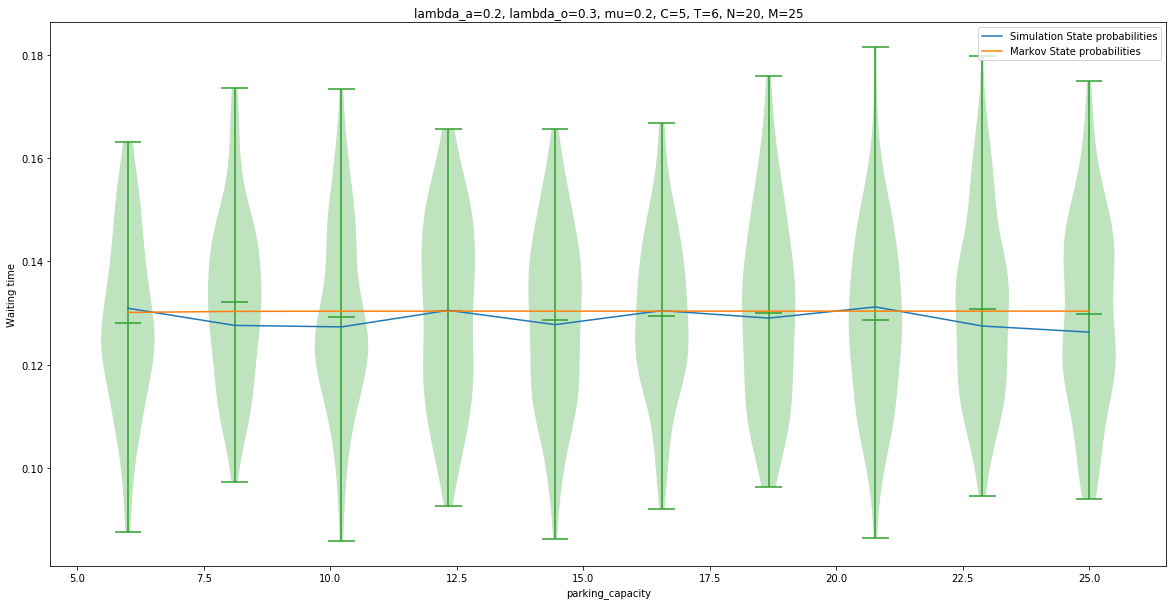

In [164]:
plot_over = "parking_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    6,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


#### Both patients waiting times:

In [165]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.2
num_of_servers = 5
threshold = 6
system_capacity = 20
parking_capacity = 20

num_of_trials = 100
seed_num = None
runtime = 10000
output = "both"
accuracy = 10


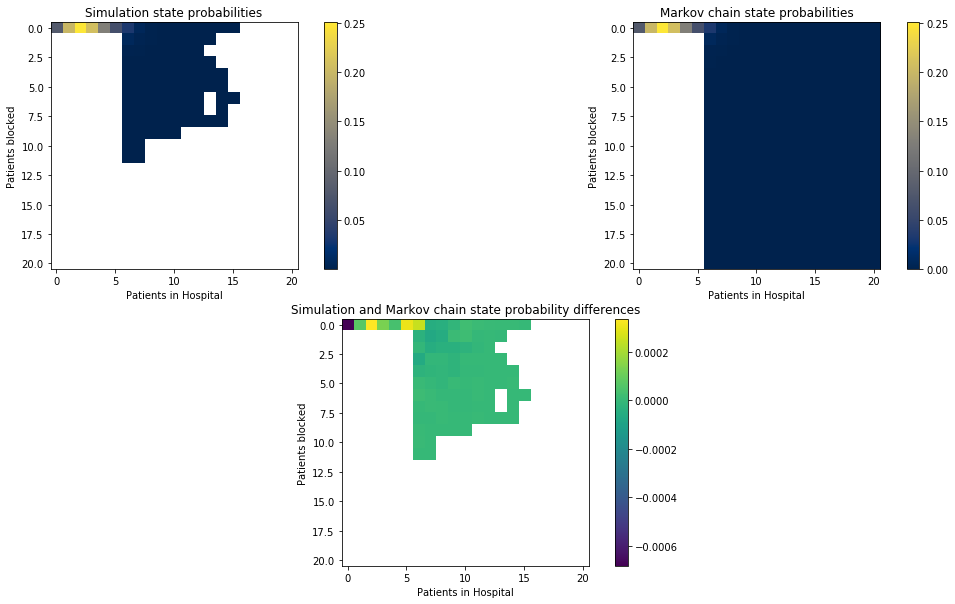

In [166]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)

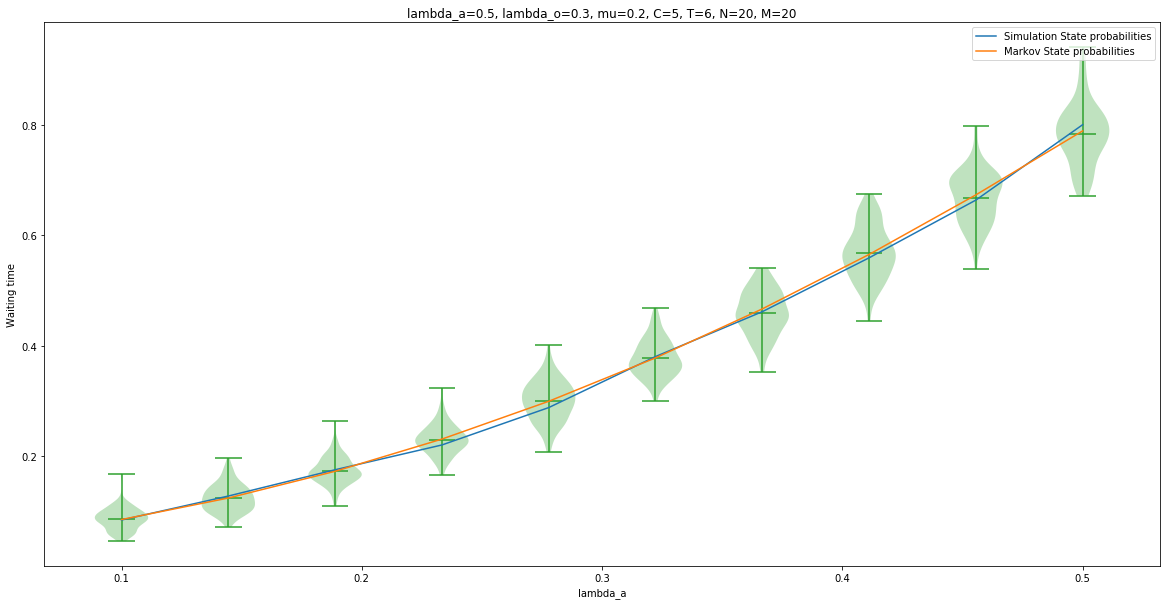

In [167]:
plot_over = "lambda_a"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

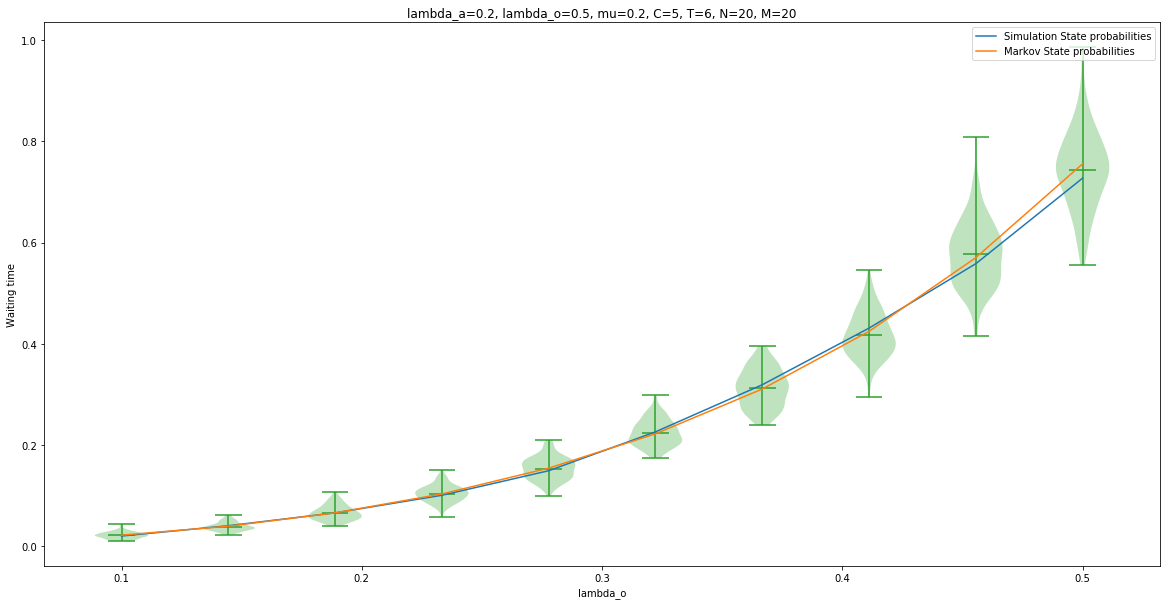

In [168]:
plot_over = "lambda_o"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

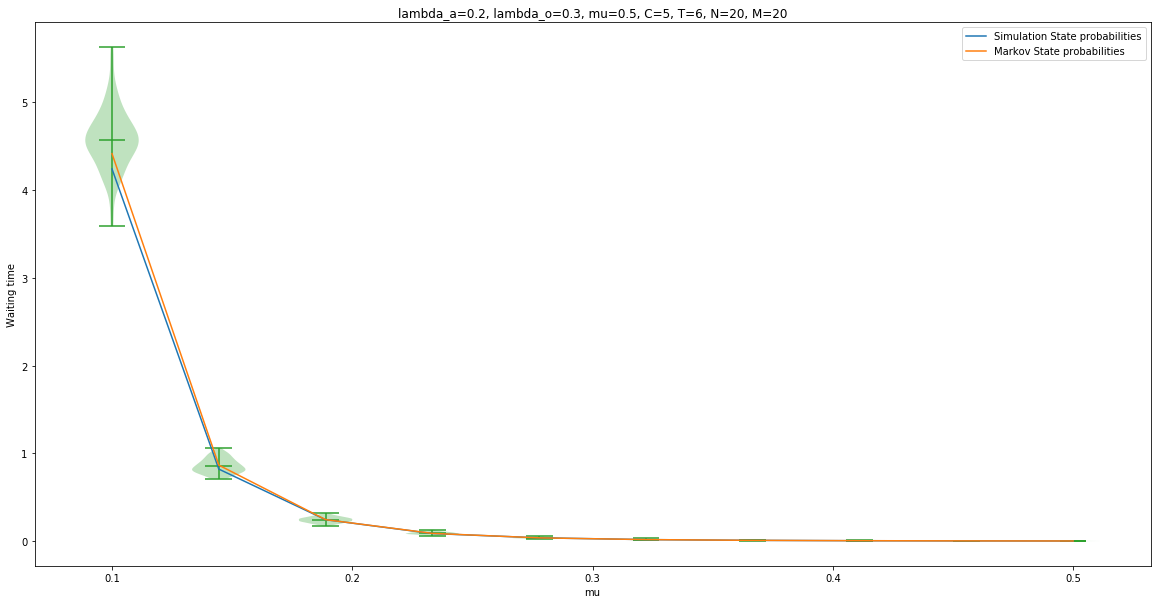

In [169]:
plot_over = "mu"
max_parameter_value = 0.5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    0.1,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


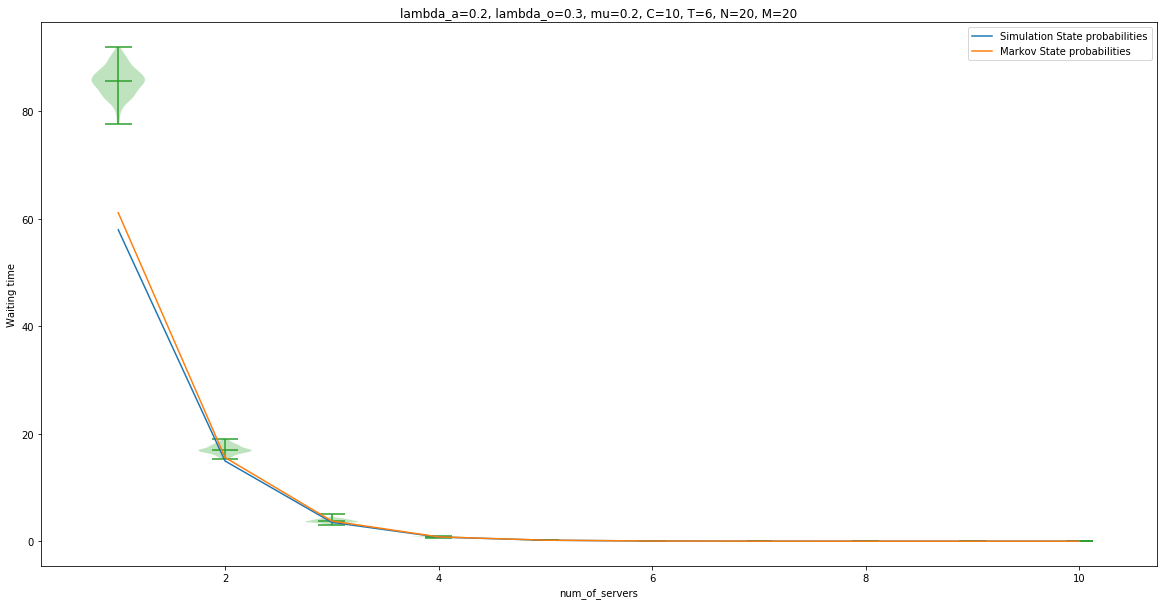

In [170]:
plot_over = "num_of_servers"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    1,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


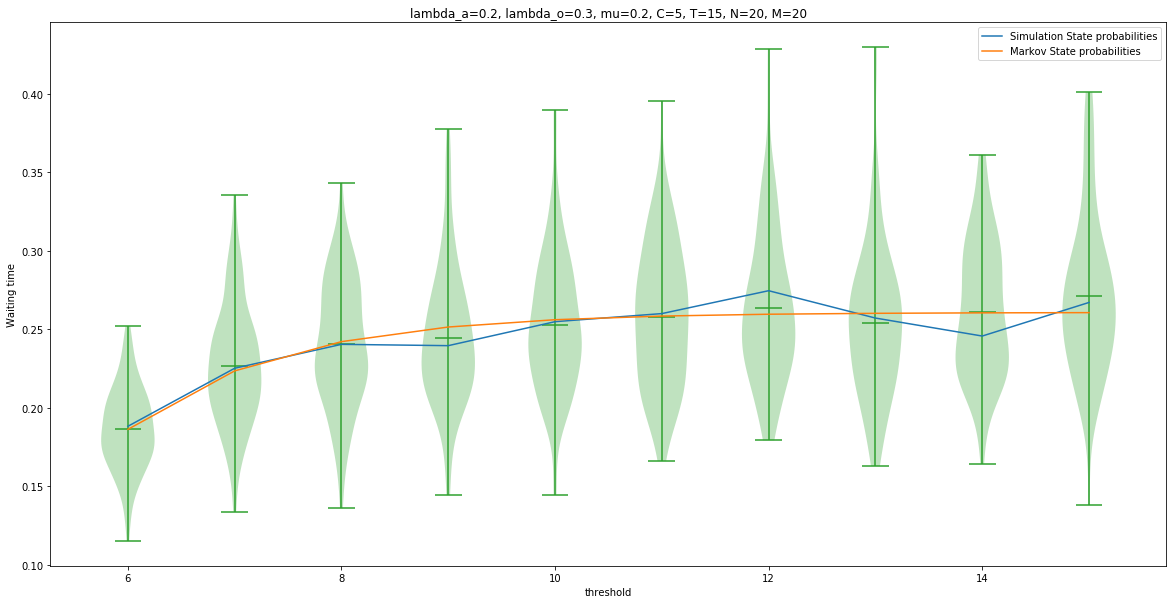

In [171]:
plot_over = "threshold"
max_parameter_value = 15
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    6,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


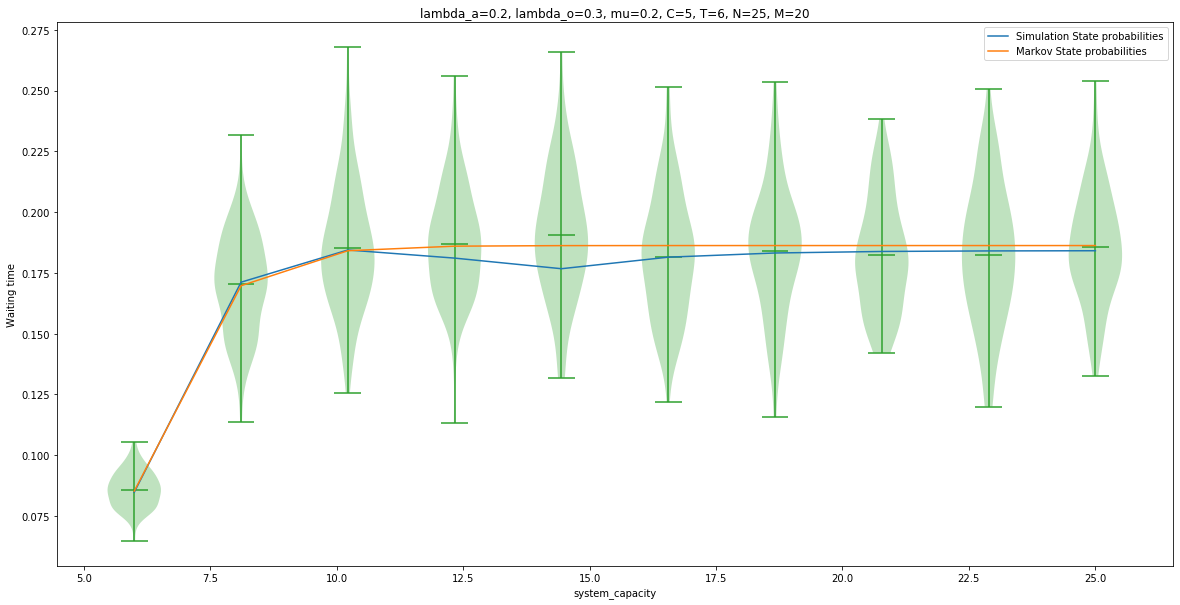

In [172]:
plot_over = "system_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    6,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


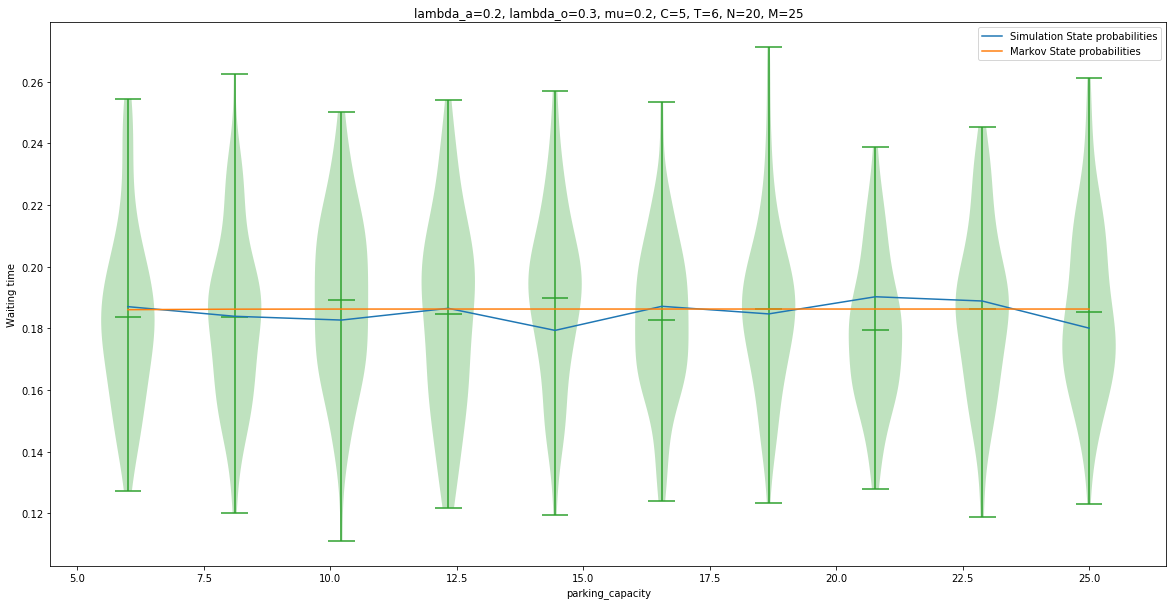

In [173]:
plot_over = "parking_capacity"
max_parameter_value = 25
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    6,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)


# Flooded models

#### Others

In [12]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.1
num_of_servers = 5
threshold = 6
system_capacity = 20
parking_capacity = 20

num_of_trials = 100
seed_num = None
runtime = 10000
output = "others"
accuracy = 20

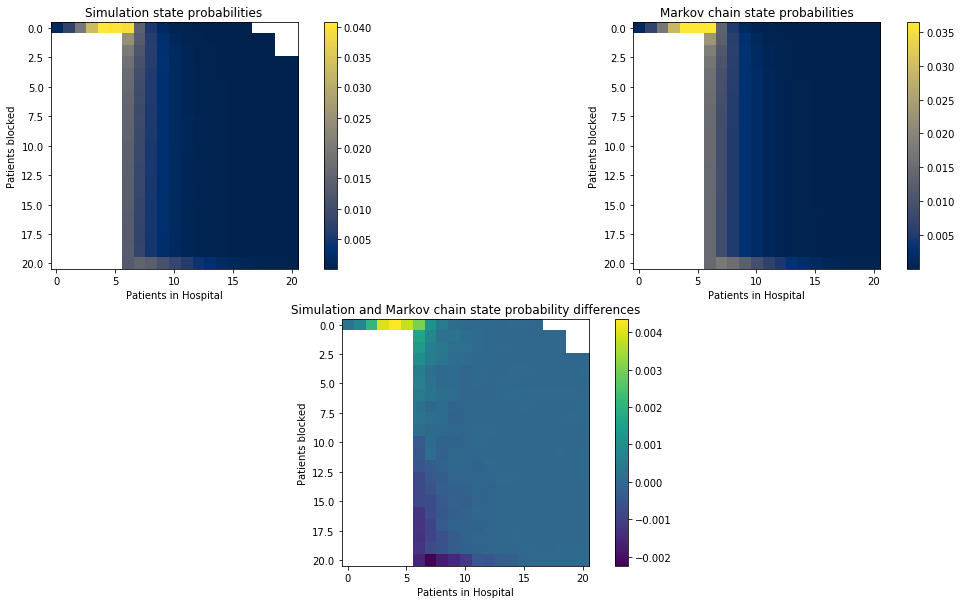

In [175]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)

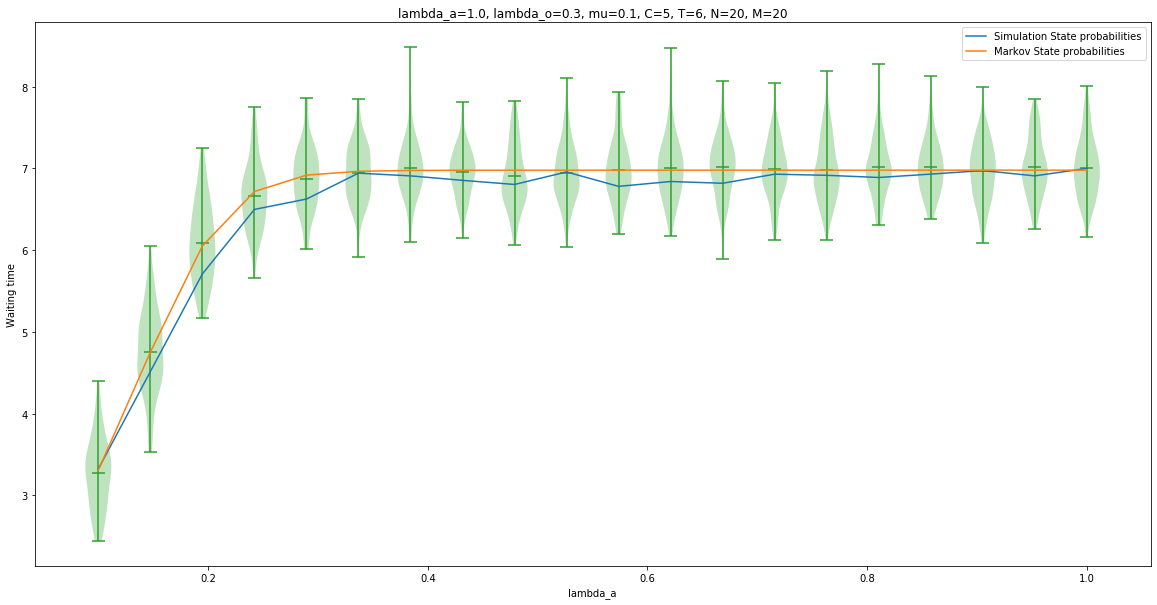

In [176]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

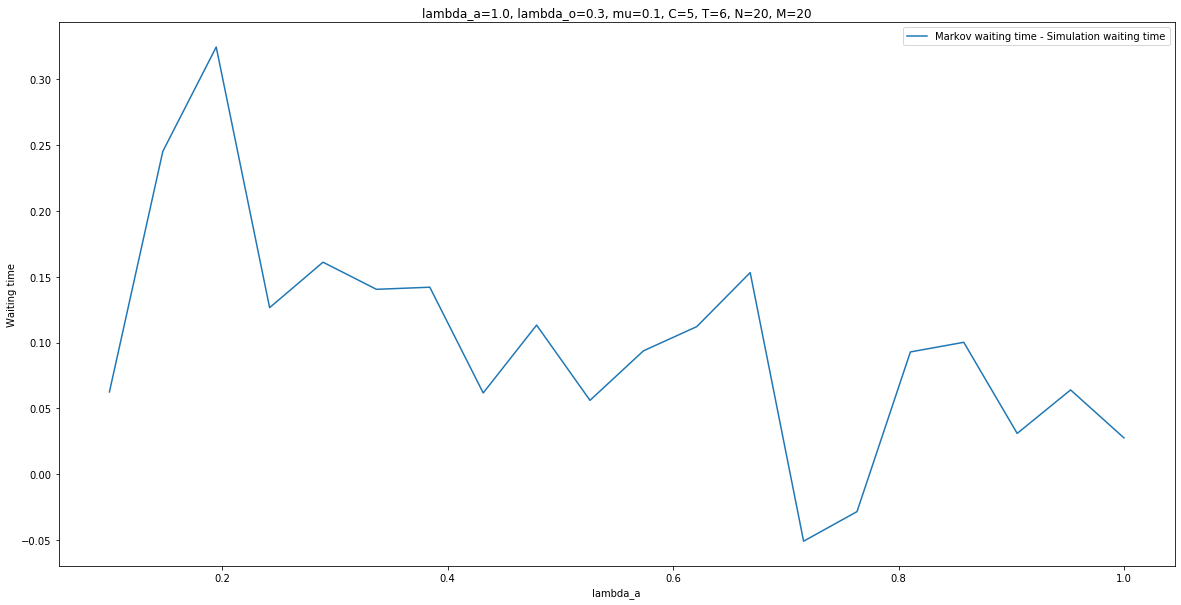

In [177]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, all_diffs = get_plot_of_difference(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

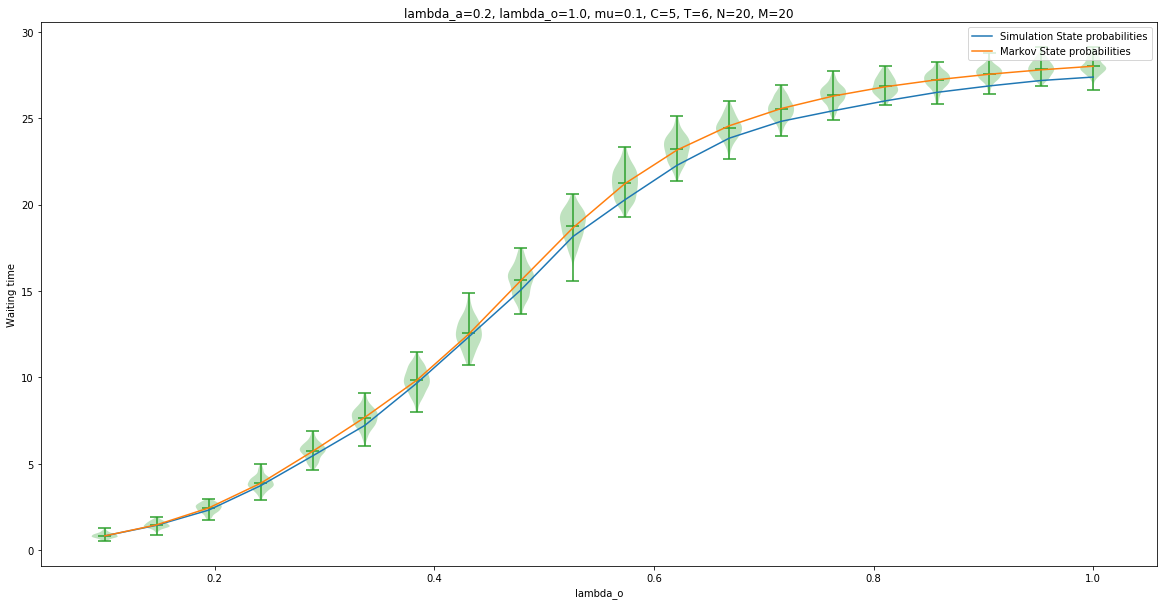

In [178]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

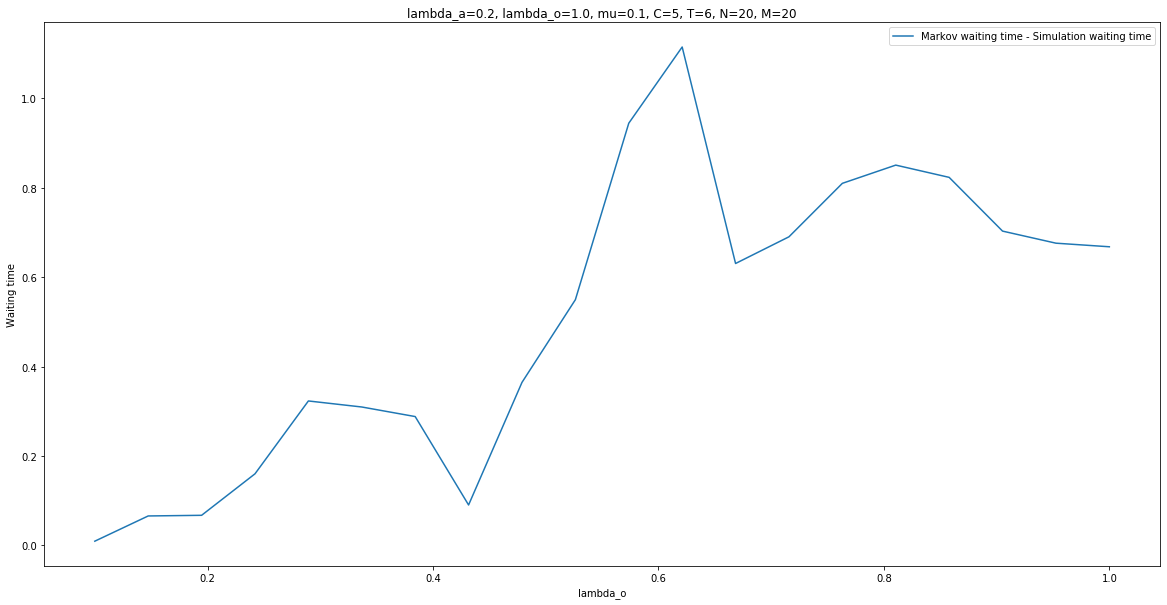

In [179]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, all_diffs = get_plot_of_difference(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

#### Ambulance

In [18]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.1
num_of_servers = 5
threshold = 6
system_capacity = 20
parking_capacity = 20

num_of_trials = 100
seed_num = None
runtime = 10000
output = "ambulance"
accuracy = 20

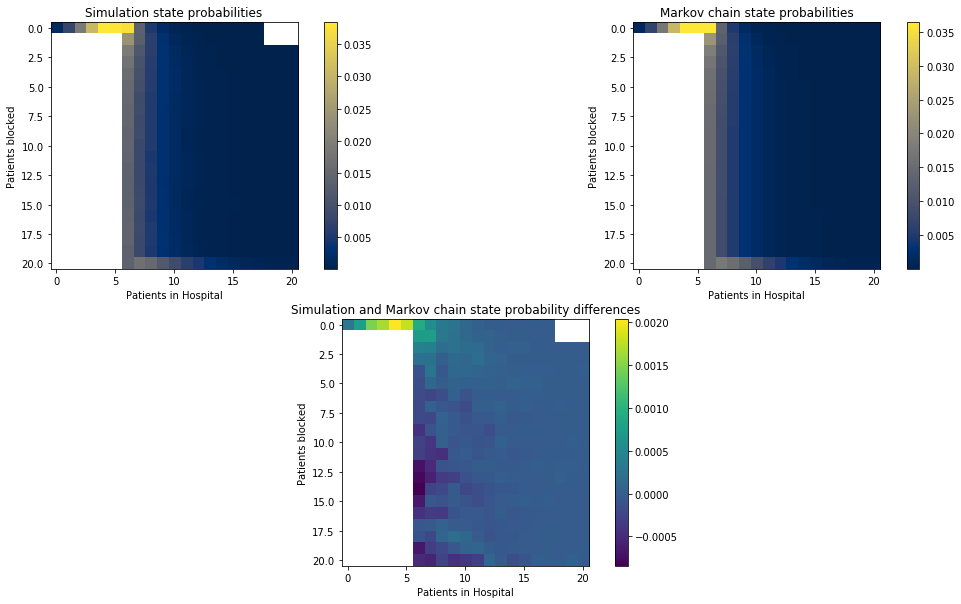

In [181]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)

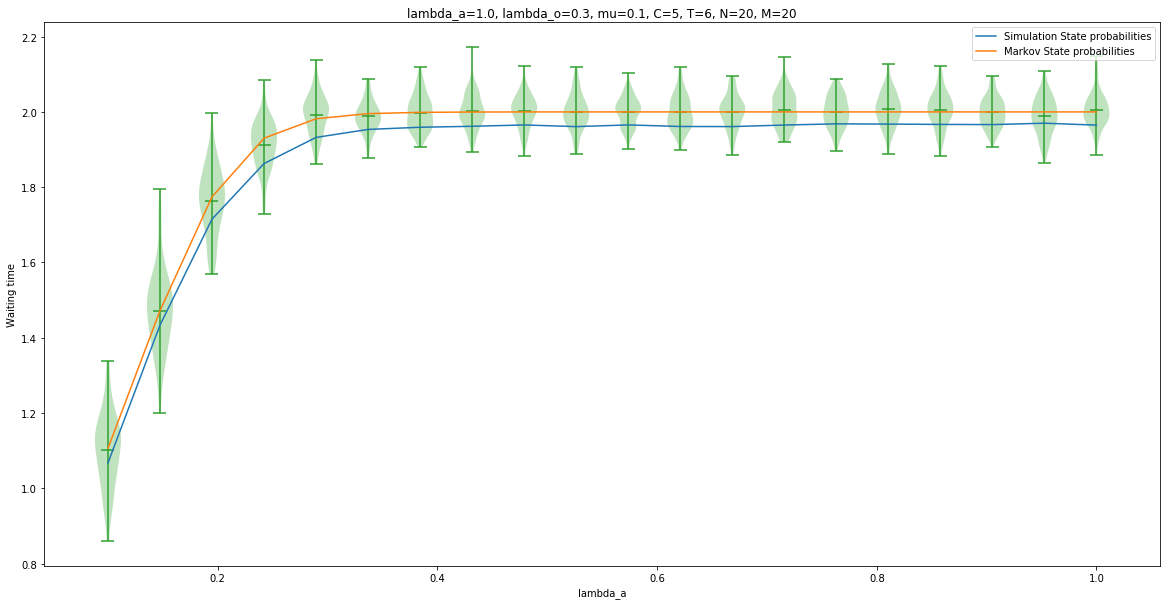

In [182]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

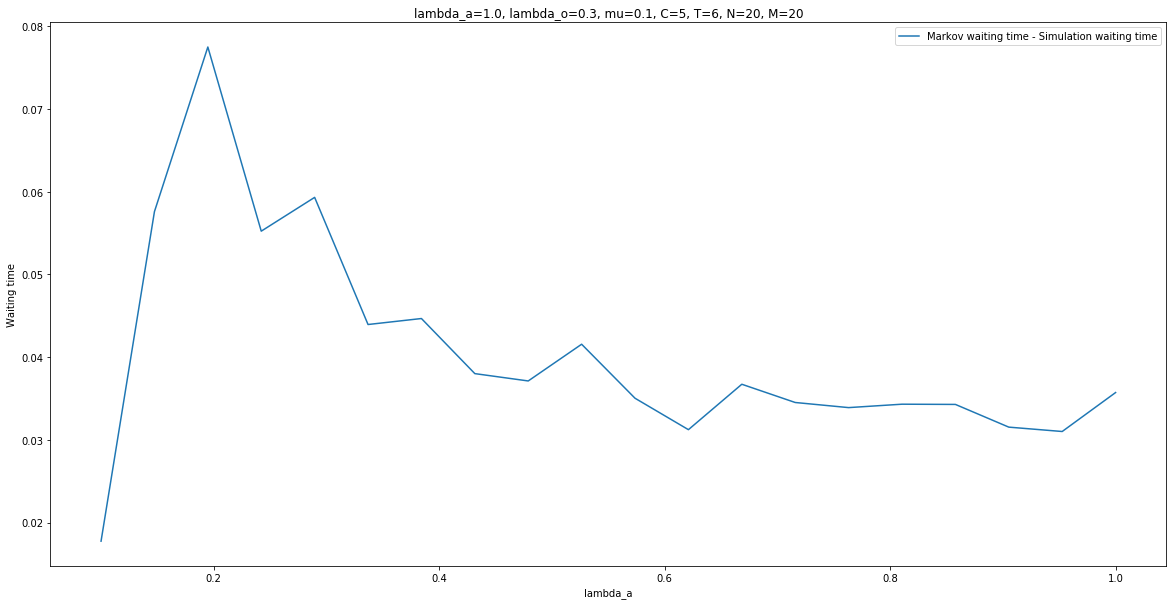

In [183]:
plot_over = "lambda_a"
max_parameter_value = 1
x_axis, all_diffs = get_plot_of_difference(
    0.1,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

C:\Users\micha\Anaconda3\envs\AmbulanceGame\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\micha\Anaconda3\envs\AmbulanceGame\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\micha\Anaconda3\envs\AmbulanceGame\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


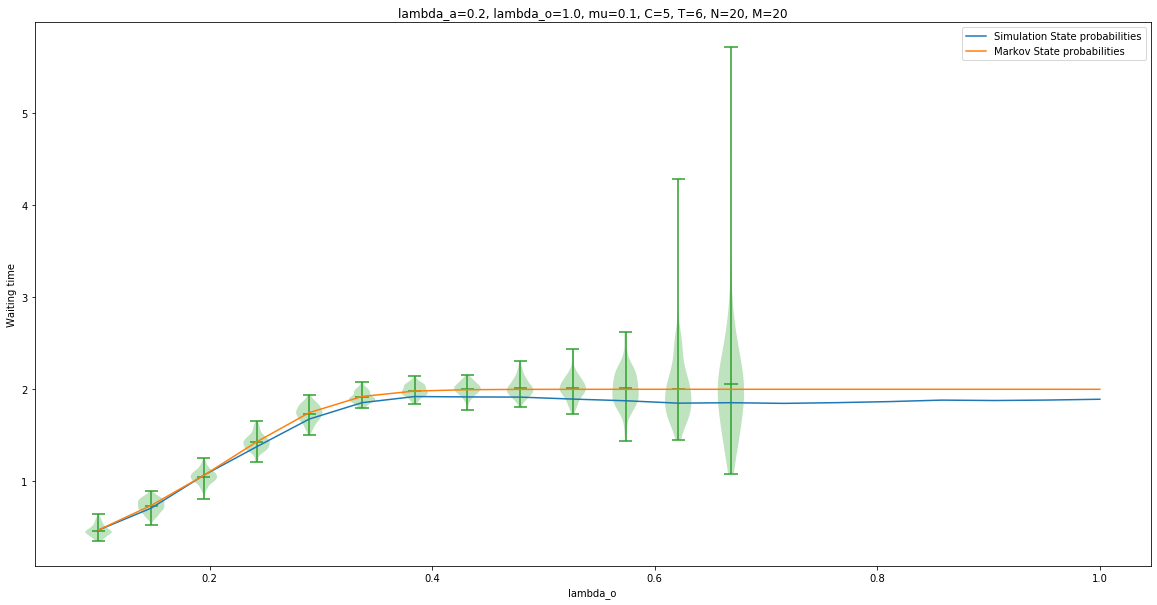

In [14]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

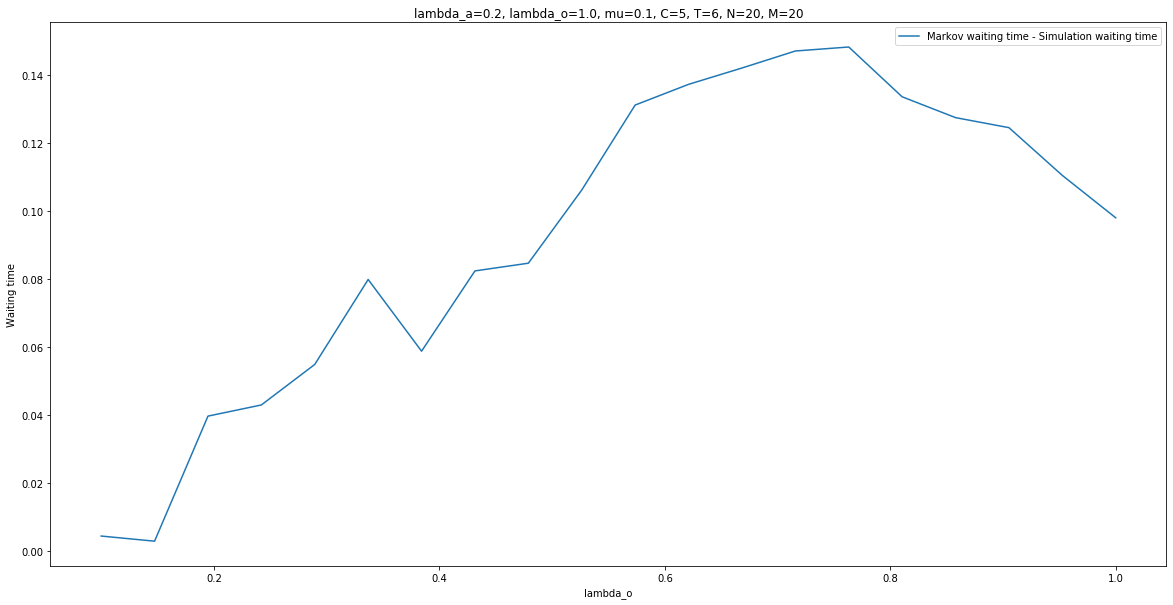

In [19]:
plot_over = "lambda_o"
max_parameter_value = 1
x_axis, all_diffs = get_plot_of_difference(
    lambda_a,
    0.1,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    output,
    plot_over,
    max_parameter_value,
    accuracy,
)

# Playing around

In [283]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.3
num_of_servers = 3
threshold = 4
system_capacity = 5
parking_capacity = 5

num_of_trials = 10
seed_num = 0
runtime = 10000
output = "ambulance"
accuracy = 5

In [111]:
times = abg.simulation.get_multiple_runs_results(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    14,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    patient_type=output
)
mean_waiting_time = np.mean([np.mean(w.waiting_times) for w in times])
print(mean_waiting_time)

14.364062587559552


In [112]:
get_mean_waiting_time_simulation(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    14,
    system_capacity,
    parking_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    output=output,
)

13.134998981020479

In [113]:
get_mean_waiting_time_markov(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    14,
    system_capacity,
    parking_capacity,
    output=output,
)

14.327638689793758